In [47]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt

import sys
import os
    
import src.paths
import src.filesystem


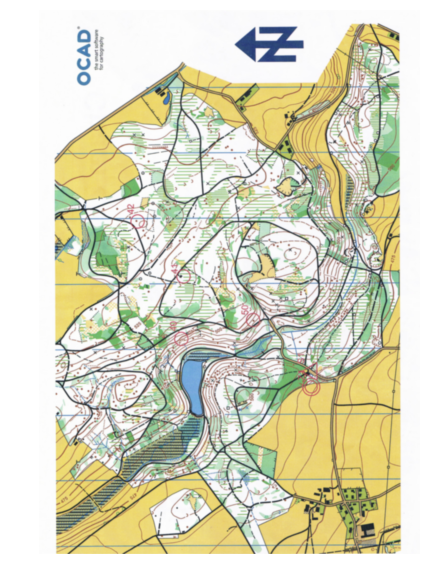

In [48]:
mapPath =  "ressources/maps/map1.jpg"
img = src.filesystem.readImg(mapPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(img, interpolation="bicubic")

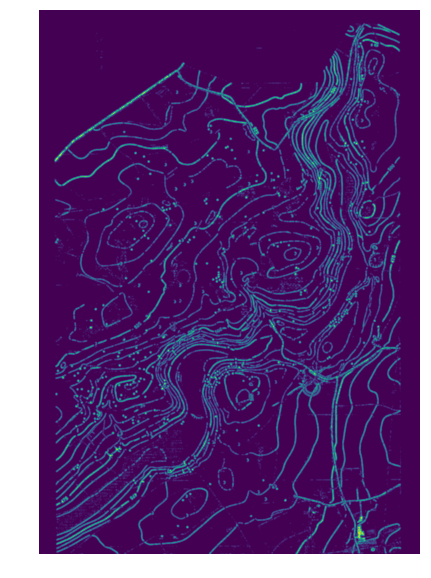

In [4]:
plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(img, interpolation="bicubic")

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

lower_brown = np.array([0, 50, 50])
upper_brown = np.array([20, 255, 255])
mask = cv2.inRange(hsv, lower_brown, upper_brown)

plt.imshow(mask, interpolation="bicubic")

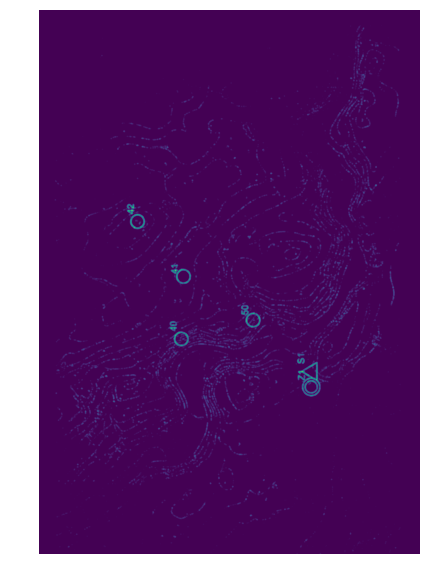

In [5]:

mask1 = cv2.inRange(hsv, np.array([0,70, 50]), np.array([0, 255, 255]))
mask2 = cv2.inRange(hsv, np.array([170, 70, 50]), np.array([180, 255, 255]))
mask = mask1 | mask2

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

[ 898 2076   45]
[1356 1960   42]
[ 912 1682   45]
[1722 2378   38]
[ 624 1338   42]
[1710 2306   48]


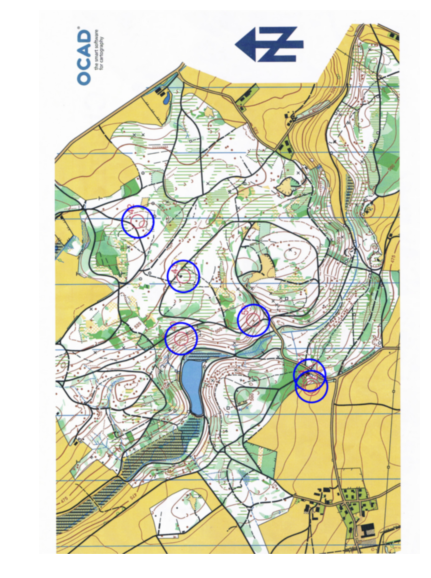

In [6]:
circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1, 30,
              param1=30,
              param2=15,
              minRadius=10,
              maxRadius=50)
circles = np.uint16(np.around(circles))

imgToDraw = np.copy(img)

for circle in circles[0][:6]:
    print(circle)
    cv2.circle(imgToDraw, (circle[0], circle[1]), 100, (0, 0, 255), 10)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(imgToDraw, interpolation="bicubic")

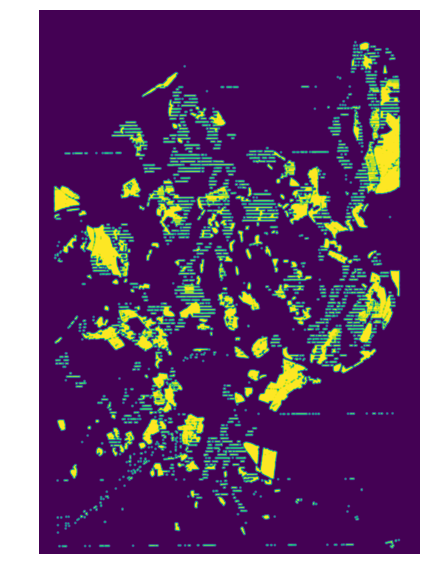

In [7]:
mask = cv2.inRange(hsv, np.array([60, 70, 150]), np.array([80, 255, 255]))

kernel = np.ones((5,5),np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 2)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

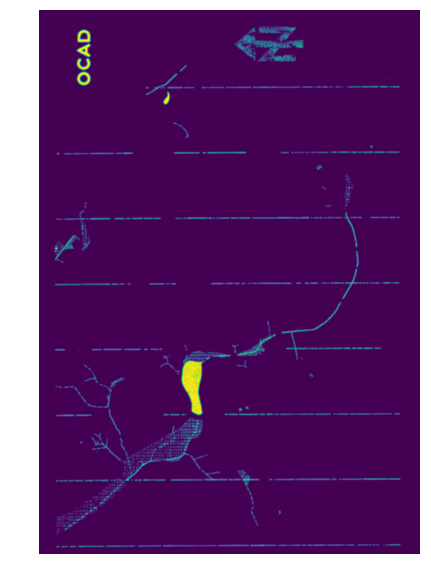

In [34]:
mask = cv2.inRange(hsv, np.array([100, 100, 120]), np.array([110, 255, 255]))

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

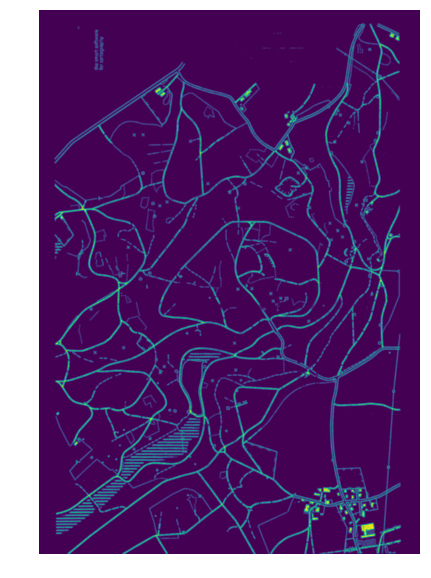

In [43]:
mask = cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 255, 60]))

kernel = np.ones((5,5),np.uint8)
#mask = cv2.dilate(mask, kernel, iterations = 2)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

(194, 259)
[[166 199 226 230 229 222 230 253 185 206 250 222 209 146 130 164  97 137
  139 179]
 [ 14  39  89 142 246 206 149 219 196 184 157 202 151 144  94  89   5 113
  112 146]
 [ 21  35  28  39  35  39  47  34  26  29  27  36  47  41  40  32  31  17
   31  29]
 [ 23  24  13  31  27  26  23  14  24  20  11  18  34  21  12  13  18  19
   14  28]
 [ 19  12   9  27  24  22  27  24  19  18  12  13  11  15  10  11  10   8
   14   5]
 [ 14  21  22  29  18  19  14  18  11  15  16  19  16   9   9   7  20  11
    7   3]
 [ 10  12  19   6  22   7  18  17  19  18   7  19  17  13   8   4  11   9
   13   9]
 [ 17  15  31  10  25  14  20  12  20  22  15  20  14  27   5  19  13   6
   19  17]
 [ 17   8  14  15  19  11  10  30  14  18  10  13  10   7  17   8  18  12
    8  10]
 [ 16   8  13  14  10  13  17   7  19  14  10  10  26  18   6   4   8   8
   11  13]
 [ 15   6  23  12  13  13  12  10  15  11   5  10  24  24  17  17   4   5
   19  10]
 [ 12  23  19  13  14  16  10  11  13   8   4   4  10 

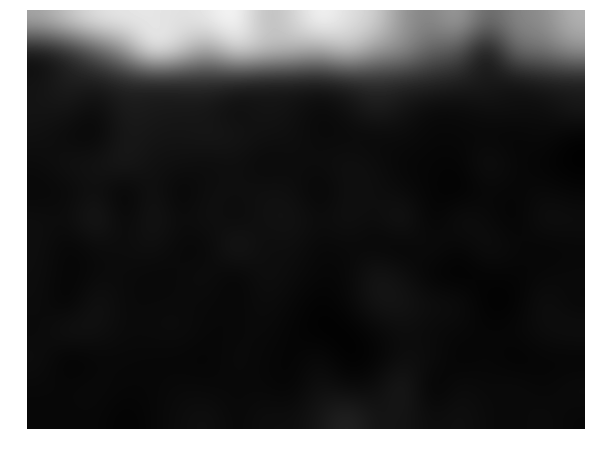

In [56]:
sd =  "ressources/maps/IMG_0183.jpg"
im = src.filesystem.readImg(sd)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


im = cv2.resize(im,(0, 0), fx=0.1, fy =0.1)
print(im.shape)

im = im[150:165, 130:150]

print(im)
cv2.imwrite("ressources/maps/IMG_0183_crop.jpg", im)
plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(im, interpolation="bicubic", cmap='gray')